<a href="https://colab.research.google.com/github/brianzhang9/Multivariate-time-series-forecasting-using-LSTM/blob/main/%E2%80%9CValue%E5%88%86%E6%9E%90%E2%80%9D%E7%9A%84_%E8%83%BD%E5%8A%9B%E5%80%BC%E4%BF%AE%E6%94%B9shap%E5%BD%92%E4%B8%80%E5%8C%96_strength.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#加载对应的库
import tensorflow as tf
import keras
import pandas as pd
from keras.models import Sequential
import numpy as np
from keras.layers import Dense, GRU, Embedding, LSTM, Bidirectional,Dropout,BatchNormalization
from keras.optimizers import adam_v2
import keras.backend as K
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [ ]:
import os
import random
def seed_tensorflow(seed=44):
  os.environ['PYTHONHASHSEED'] = str(seed) 
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)
  os.environ['TF_DETERMINISTIC_OPS'] = '1' # `pip install tensorflow-determinism` first,使用与tf>2.1
seed_tensorflow(44)

In [ ]:
# 创建训练优化器，如果loss已经收敛就早点停止
early_stopping = EarlyStopping(monitor="val_keras_r2_score",patience=200,mode="max",restore_best_weights=True)

In [ ]:
# 计算R2分数，用来评价模型
def keras_r2_score(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())

In [ ]:
# 加载数据
data = pd.read_csv("计算结果-滤波后-差分计算.csv")
data

,timestamp,Capacityh,Capacityz,Rz,Fz,Rg,Fg,Uc,T,Cc,Fri,Miu,Capacityh1,Capacityz1,Force-1,Force-2,Ca,St
0,0.12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,-0.024559,0.009421,0.000000,0.000000,0.000000,0.000000,0.032597,2158.430000
1,0.24,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.021126,0.002344,0.000000,0.000000,0.000000,0.000000,0.032597,2158.430000
2,0.36,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.015652,0.000831,0.000000,0.000000,0.000000,0.000000,0.032597,2158.430000
3,0.48,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.028614,0.000635,0.000000,0.000000,0.000000,0.000000,0.032597,2158.430000
4,0.60,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,0.000000,0.012329,0.000701,0.000000,0.000000,0.000000,0.000000,0.032597,2158.430000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,119.40,0.000063,0.000123,0.051535,0.151192,-0.078209,-0.440911,0.011716,119,-0.008253,-0.001355,0.000199,0.062614,0.123233,5.071212,2.620566,0.031642,1693.106667
995,119.52,-0.000044,-0.000106,-0.046883,-0.138925,0.074120,0.422362,-0.011389,120,0.007884,-0.007516,-0.000140,-0.044435,-0.106349,-4.418096,-2.386540,0.031597,1688.688571
996,119.64,-0.000100,-0.000191,-0.084280,-0.249739,0.125695,0.715096,-0.020470,120,0.013101,-0.013692,0.000485,-0.099983,-0.191429,-8.362571,-4.292971,0.031497,1680.326000
997,119.76,0.000300,0.000553,0.258652,0.782934,-0.203328,-1.163789,0.092211,120,-0.021735,-0.001291,-0.000199,0.299940,0.553333,26.607333,13.596400,0.031797,1706.933333


In [ ]:
# 查看数据信息
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   timestamp   999 non-null    float64
 1   Capacityh   999 non-null    float64
 2   Capacityz   999 non-null    float64
 3   Rz          999 non-null    float64
 4   Fz          999 non-null    float64
 5   Rg          999 non-null    float64
 6   Fg          999 non-null    float64
 7   Uc          999 non-null    float64
 8   T           999 non-null    int64  
 9   Cc          999 non-null    float64
 10  Fri         999 non-null    float64
 11  Miu         999 non-null    float64
 12  Capacityh1  999 non-null    float64
 13  Capacityz1  999 non-null    float64
 14  Force-1     999 non-null    float64
 15  Force-2     999 non-null    float64
 16  Ca          999 non-null    float64
 17  St          999 non-null    float64
dtypes: float64(17), int64(1)
memory usage: 140.6 KB


In [ ]:
# 加载划分训练集测试集的数据
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,StandardScaler
feature_cols = ["Uc","Rg","Rz"]
target_col = "Force-1"

In [ ]:
# 处理模型输入和输出
features = data.loc[:,feature_cols].values
targets = data.loc[:,target_col].values[:,np.newaxis]

In [ ]:
# 划分训练集和测试集合，这里不随机打乱，后续要计算根据时间的特征表现
X_train, X_test, y_train, y_test = train_test_split(features,targets,test_size=0.2,shuffle=False)

In [ ]:
# 对数据进行归一化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)[:,np.newaxis,:]
X_test = scaler.transform(X_test)[:,np.newaxis,:]
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train)
y_test = y_scaler.transform(y_test)

In [ ]:
# 创建模型
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
#model.add(LSTM(100, input_shape=(X_train.shape[1:5])))

model.add(BatchNormalization())
model.add(Dense(64,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(1))
optimizer = adam_v2.Adam(learning_rate=1e-4)
model.compile(loss='mse',  optimizer = optimizer,metrics=['mse',keras_r2_score])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               41600     
                                                                 
 batch_normalization (BatchN  (None, 100)              400       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 64)                6464      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 52,689
Trainable params: 52,489
Non-trainable params: 200
__________________________________________________

In [ ]:
# 训练模型
history = model.fit(X_train,y_train,batch_size=256,epochs=1000,validation_data=(X_test,y_test),callbacks=[early_stopping])

Epoch 1/1000
4/4 [==============================] - 3s 223ms/step - loss: 1.4734 - mse: 1.4734 - keras_r2_score: -0.4464 - val_loss: 3.3967 - val_mse: 3.3967 - val_keras_r2_score: -0.0290
Epoch 2/1000
4/4 [==============================] - 0s 18ms/step - loss: 1.3230 - mse: 1.3230 - keras_r2_score: -0.3057 - val_loss: 3.3738 - val_mse: 3.3738 - val_keras_r2_score: -0.0221
Epoch 3/1000
4/4 [==============================] - 0s 17ms/step - loss: 1.1817 - mse: 1.1817 - keras_r2_score: -0.2035 - val_loss: 3.3509 - val_mse: 3.3509 - val_keras_r2_score: -0.0151
Epoch 4/1000
4/4 [==============================] - 0s 17ms/step - loss: 1.0544 - mse: 1.0544 - keras_r2_score: -0.1462 - val_loss: 3.3284 - val_mse: 3.3284 - val_keras_r2_score: -0.0083
Epoch 5/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.9359 - mse: 0.9359 - keras_r2_score: 0.0459 - val_loss: 3.3072 - val_mse: 3.3072 - val_keras_r2_score: -0.0019
Epoch 6/1000
4/4 [==============================] - 0s 20ms/step 

In [ ]:
# 画结果图
def plot(data,mode="all"):
    if mode == "all":
        test_data = data
    elif mode == "train":
        test_data = data.iloc[:int(0.8 * len(data)),:]
    elif mode == "test":
        test_data = data.iloc[int(0.8 * len(data)):,:]
    test_features = test_data.loc[:,feature_cols].values
    test_targets = test_data.loc[:,target_col].values[:,np.newaxis]
    pred = model.predict(scaler.transform(test_features)[:,np.newaxis,:])
    true = y_scaler.transform(test_targets)
    pred = y_scaler.inverse_transform(pred)
    true = y_scaler.inverse_transform(true)
    print(r2_score(true,pred))
    plt.figure(figsize=(6,3))
    plt.plot(true,label="true value")
    plt.plot(pred,label="pred value")
    plt.legend()
    plt.savefig('pre.svg',format='svg',dpi=150)
    plt.show()

7/7 [==============================] - 1s 3ms/step
0.9811624299321583


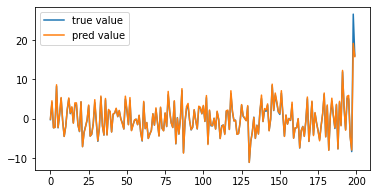

In [ ]:
fig = plot(data,mode="test")

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 5.1 MB/s 


In [ ]:
# 定义模型的预测方式
import shap
def f(X):
    # return model.predict([X[:,i] for i in range(X.shape[1])]).flatten()
    return model.predict(np.expand_dims(X, 1)).flatten()

In [ ]:
# 计算对应的shap值
features = scaler.transform(features)
input_X = features
explainer = shap.KernelExplainer(f, input_X.squeeze())
shap_values = explainer.shap_values(input_X, nsamples=500)

32/32 [==============================] - 0s 4ms/step


  0%|          | 0/999 [00:00<?, ?it/s]

188/188 [==============================] - 0s 2ms/step


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values,data.loc[:,feature_cols])
#fig = shap.force_plot(explainer.expected_value, shap_values,data.loc[:,feature_cols])
#shap.plots.force(explainer.expected_value, shap_values,data.loc[:,feature_cols], show=False, matplotlib=True).savefig('shap1.svg')
#plt.savefig('shap.svg',format='svg',dpi=1000)

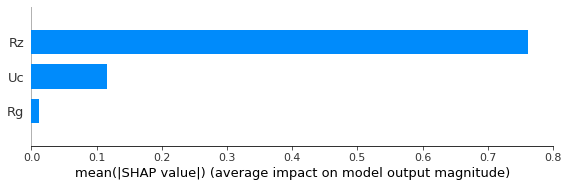

In [ ]:
shap.initjs()
fig = shap.summary_plot(shap_values, data.loc[:,feature_cols], plot_type='bar', show=False)
plt.savefig('shap.svg',format='svg',dpi=150)

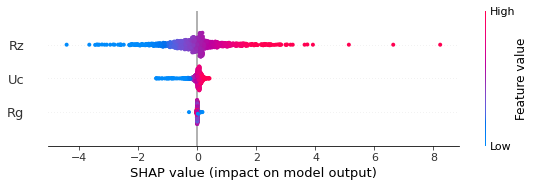

In [ ]:
shap.initjs()
fig = shap.summary_plot(shap_values, data.loc[:,feature_cols], show=False)
plt.savefig('shap2.svg',format='svg',dpi=150)

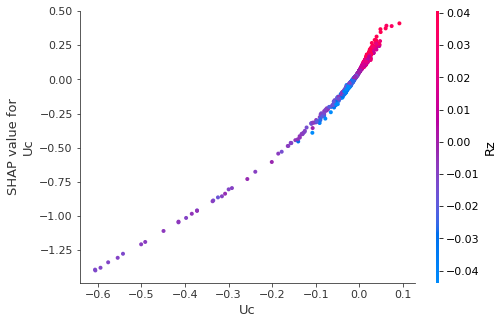

In [ ]:
shap.initjs()
shap.dependence_plot("Uc", shap_values, data.loc[:,feature_cols])